In [1]:
# Setting auto reloading for imported modules
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from auxiliary_functions import PreprocessingUtils

In [3]:
utils = PreprocessingUtils()

In [4]:
df = pd.read_csv('../data/clean_data/df_sessions_w_feats.csv')
df.head()

,CR,is_organic,is_social_media_ad,in_app_browser,is_top_browser,is_popular_brand,utm_source_(not set),utm_source_aeiciopgciauosisathm,utm_source_ahgbtejtesiumjouidys,utm_source_akopqaqajrlgbjrrivph,...,geo_country_venezuela,geo_country_vietnam,geo_country_wallis & futuna,geo_country_yemen,geo_country_zimbabwe,utm_campaign_te,utm_keyword_te,geo_city_te,screen_width_std,screen_height_std
0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029096,0.024005,0.013889,-0.538619,-0.633628
1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010415,0.015396,0.031466,-0.493538,0.079150
2,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029096,0.024005,0.024602,-0.538619,-0.633628
3,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036736,0.033880,0.031466,-0.479112,-0.282558
4,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036736,0.033880,0.031466,-0.479112,-0.282558


In [5]:
x = df.drop(['CR'], axis=1)
y = df['CR']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Initial model training without any fine-tuning

In [6]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

GradientBoostingClassifier()

In [7]:
y_pred = gbc.predict(x_test)
y_pred_prob = gbc.predict_proba(x_test)[:, 1]

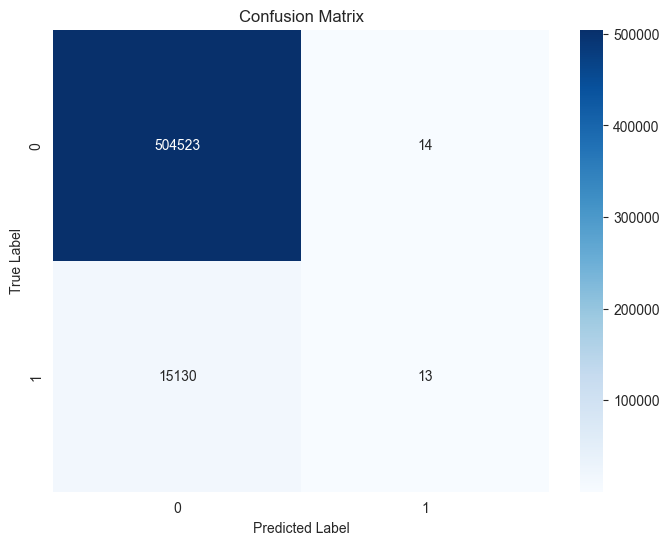

Accuracy: 0.97
F1 Score: 0.00
ROC-AUC Score: 0.69


In [8]:
metrics_result = utils.evaluate_model(y_test, y_pred, y_pred_prob)

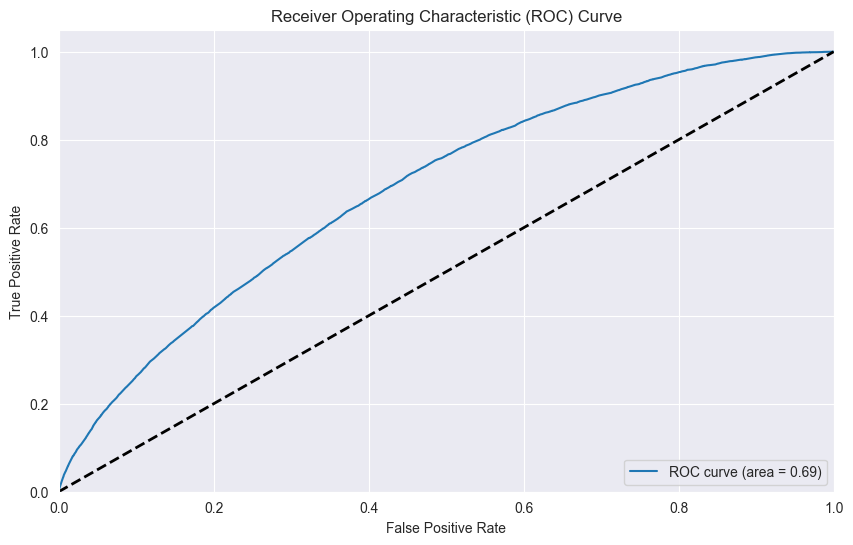

In [9]:
utils.create_roc_auc_curve(metrics_result['roc_auc'], y_test, y_pred_prob)

Using sample weights to give more importance to the minority class to improve model performance

In [10]:
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 1] = 25

gbc_weighted = GradientBoostingClassifier()
gbc_weighted.fit(x_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier()

In [11]:
y_pred_weighted = gbc_weighted.predict(x_test)
y_pred_prob_weighted = gbc_weighted.predict_proba(x_test)[:, 1]

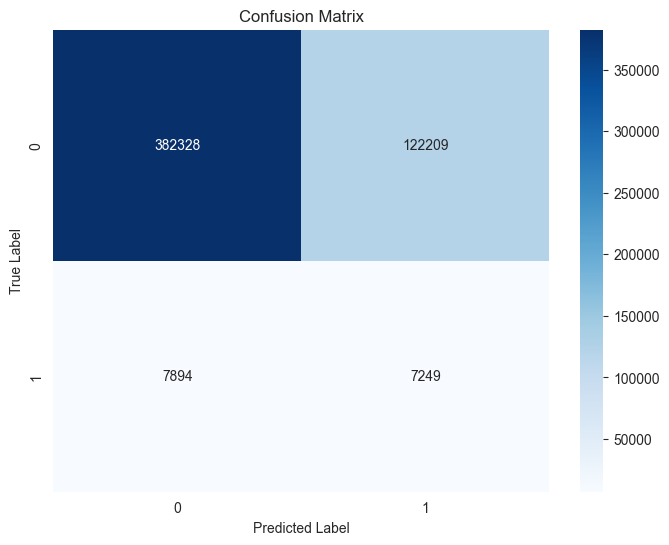

Accuracy: 0.75
F1 Score: 0.10
ROC-AUC Score: 0.69


In [12]:
metrics_result_weighted = utils.evaluate_model(y_test, y_pred_weighted, y_pred_prob_weighted)

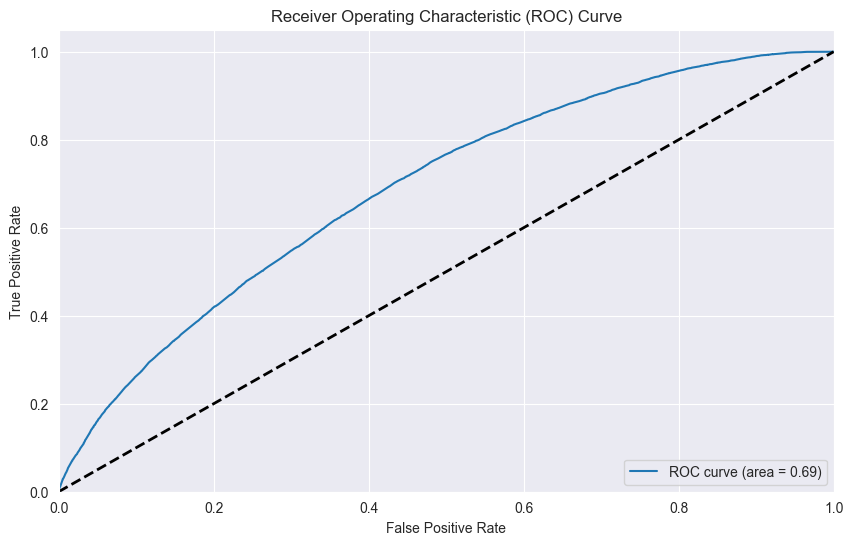

In [13]:
utils.create_roc_auc_curve(metrics_result_weighted['roc_auc'], y_test, y_pred_prob_weighted)

Using randomized search for hyperparameter tuning

In [19]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
}

In [22]:
gbs_tuned = GradientBoostingClassifier()
random_search = RandomizedSearchCV(gbs_tuned, param_distributions=param_dist, cv=3, n_iter=30, random_state=42, scoring='f1')

In [ ]:
random_search.fit(x_train, y_train, sample_weight=sample_weights)
best_model = random_search.best_estimator_